In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
import re
from collections import Counter

from music21 import *
from analysis_functions import *

In [2]:
#clearing out old files
!rm *.mid
!rm *.pkl


rm: cannot remove '*.mid': No such file or directory
rm: cannot remove '*.pkl': No such file or directory


INTRODUCTION

A (mostly) integrated workflow for generating melodies for the exposure, forced-choice, and slider/interpretation parts of the experiment.

How to use:
Part 1 uses markov grammar to generate a sequence of strings which correspond to pitches ('C4', etc.). There are separate grammars defined for melodies starting on A3 or A4 (to make sure listeners are paying attention). 

Part 2 generates some analyses of the sequences generated and compares this data to what is theoretically expected.

Part 3 converts the string sequences into midi files. Run all cells above part 3 for each type of melody to be generated so that there are different melodies for each part of the experiment.

Part 4 convert midi files to mp3 so that they can be used with jspsych. Currently using colab to convert because the command line function here is for linux...

Parameters

In [84]:
#how many melodies to generate
corpus_size = 10
num_ag_melodies = 1

#tempo
current_tempo = tempo.MetronomeMark(number=168)

#determines what 'key' the melody is in
tonic = 3

PART 1: MARKOV SEQUENCE GENERATION

The grammar generates highly controlled melodies with predefind target notes and 2 predefined context notes


In [85]:
#defining the different sections of the melody
#----------------starting segment-------------------------

matrix_start = organize_matrix({
   1: [0, 0, 0, 0, 0],
   2: [.95, 0, 0, 0, 0],
   3: [.05, .05, 0, 0, 0],
   6: [0, .9, 1, 0, 0],
   'end': [0, .05, 0, 1, 1]
})

def start_melody():
    #define the starting note
    results = [1]

    #appending new notes to the starting state until max number of notes reached
    #while len(results) < length:
    while 'end' not in results:
      new_state = np.random.choice(matrix_start.index, p = matrix_start.loc[results[-1]])
      results.append(new_state)
    
    results.remove('end')
    return results

#print(start_melody())

#-------------------target note sections----------------------------------
def target_alpha():
    result = [3]
    a = np.random.choice([2, 4], p = [0.05, 0.95])
    result.append(a)
    return result


def target_beta():
    result = [5]
    a = np.random.choice([6, 4], p = [0.05, 0.95])
    result.append(a)
    return result

#print(target_alpha()+target_beta())

#---------------------------intermediate section between target sections-----------------

matrix_int = organize_matrix({
    2: [0, 0, 0, .2, .5, 0],
    3: [0, 0, 0, 0, 0, 0],
    5: [0, 0, 0, 0, 0, 0],
    6: [.2, 0, 0, 0, .5, 0],
    7: [0, 1, 1, 0, 0, 0],
    'end': [.8, 0, 0, .8, 0, 1]
})
def int_melody():
    #define the starting note
    results = [np.random.choice([5, 3], p = [0.5, 0.5])]

    #appending new notes to the starting state until max number of notes reached
    #while len(results) < length:
    while 'end' not in results:
      new_state = np.random.choice(matrix_int.index, p = matrix_int.loc[results[-1]])
      results.append(new_state)
    
    results.remove('end')
    return results

#print(int_melody())

#----------------------------------ending section----------------------------------
def end_melody():
  # return [1]
    results = np.random.choice([[5,3,1],[3,1]])
    return results

#print(end_melody())

In [86]:
degrees = [1,2,3,4,5,6,7]
#totally random pitch assignment, and with 6 scale degrees (incl 1 tonic)
"""

pitches = ['A3', 'Bb3', 'C4', 'C#4', 'E4', 'G4', 'A4']

original_pitchmap = {'one': 'A3', 'two': 'Bb3', 'three': 'C4', 'four': 'C#4', 'five': 'E4', 'six': 'G4'}
random.shuffle(pitches)
random_pitchmap = {degrees[i]: pitches[i] for i in range(len(degrees))}
"""

#rotational pitch assignment preserving relationships between scale degrees (incl 2 tonics)
pitchpool = ['A3', 'Bb3', 'C4', 'C#4', 'E4', 'G4', 'A4', 'Bb4', 'C5', 'C#5', 'E5', 'G5']

#tonic = int(np.random.choice(np.linspace(0,5,6))) #randomly assigns tonic, but we want to control it
#tonic = 5
pitches = pitchpool[tonic:tonic+7]
print(pitches)

rotated_pitchmap = {degrees[i]: pitches[i] for i in range(len(degrees))}

print(rotated_pitchmap)

['C#4', 'E4', 'G4', 'A4', 'Bb4', 'C5', 'C#5']
{1: 'C#4', 2: 'E4', 3: 'G4', 4: 'A4', 5: 'Bb4', 6: 'C5', 7: 'C#5'}


In [87]:
#generating a sequence of scale degrees

def generate_sequence():
    #choice = 1
    choice = np.random.choice([1,2])
    if choice == 1:
        sequence = start_melody() + target_alpha() + int_melody() + target_beta() + end_melody()
    elif choice == 2:
        sequence = start_melody() + target_beta() + int_melody() + target_alpha() + end_melody()
    return sequence 

#converting scale degrees to pitches, randomly assigning a pitch to a degree
#keeping the original pitch map for now but can try different conditions where there are different mappings
def seq_to_pitch(sequence):    
    #return [*map(original_pitchmap.get, sequence)]
    return [*map(rotated_pitchmap.get, sequence)]

#generating a single melody
def generate_melody():
    new_sequence = generate_sequence()
    new_melody = seq_to_pitch(new_sequence)
    return new_melody, new_sequence

#generating a nested list of melodies
def generate_melody_set(num_melodies):
    melody_list = []
    sequence_list = []
   # melody_data = pd.DataFrame(columns=['sequence', 'cell order'])

    while len(melody_list) < num_melodies:
        melody, sequence = generate_melody()
        melody_list.append(melody)
        sequence_list.append(sequence)

    return melody_list, sequence_list 

In [88]:
melody_list, sequence_list = generate_melody_set(corpus_size)

<ipython-input-85-8f1abadd184a>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.random.choice([[5,3,1],[3,1]])


Agrammatical melodies

In [89]:
#exchanging pitches 5 and 6 in the degree to pitch assignment
ag_pitches = pitches[::]
ag_pitches[5], ag_pitches[6] = ag_pitches[6], ag_pitches[5]
print(ag_pitches, pitches)
ag_pitchmap = {degrees[i]: ag_pitches[i] for i in range(len(degrees))}

def seq_to_pitch_ag(sequence):    
    #return [*map(original_pitchmap.get, sequence)]
    return [*map(ag_pitchmap.get, sequence)]


['C#4', 'E4', 'G4', 'A4', 'Bb4', 'C#5', 'C5'] ['C#4', 'E4', 'G4', 'A4', 'Bb4', 'C5', 'C#5']


In [90]:
ag_melody_list = []
for i in range(num_ag_melodies+1):
    ag_seq = seq_to_pitch_ag(sequence_list[i])
    ag_melody_list.append(ag_seq)

ag_melody_list

[['C#4', 'E4', 'C#5', 'Bb4', 'A4', 'G4', 'C5', 'C#5', 'G4', 'A4', 'G4', 'C#4'],
 ['C#4',
  'G4',
  'C#5',
  'Bb4',
  'A4',
  'Bb4',
  'C5',
  'C#5',
  'G4',
  'A4',
  'G4',
  'C#4']]

PART 2: ANALYSES OF SEQUENCES

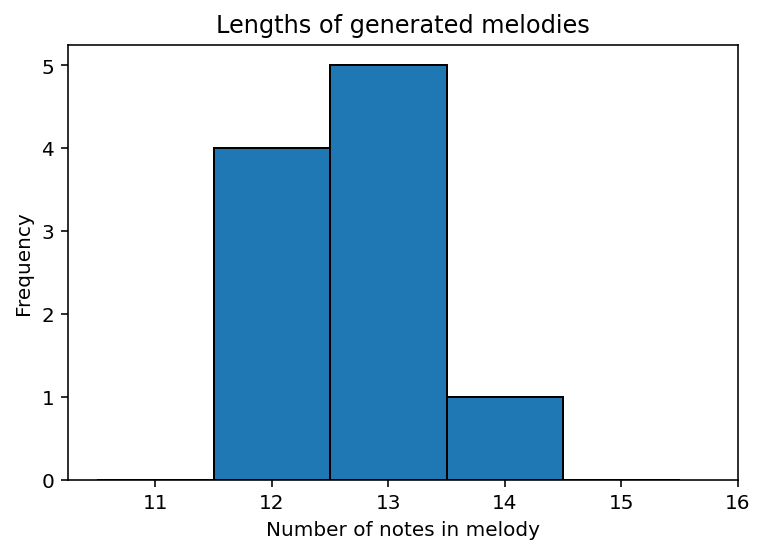

In [91]:
#plotting length of melodies - should be done before the corpus cleanup
#print(melody_list)

length_plot(melody_list)
plt.savefig('supp_melody_length.png', dpi = 300)

<ipython-input-85-8f1abadd184a>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.random.choice([[5,3,1],[3,1]])


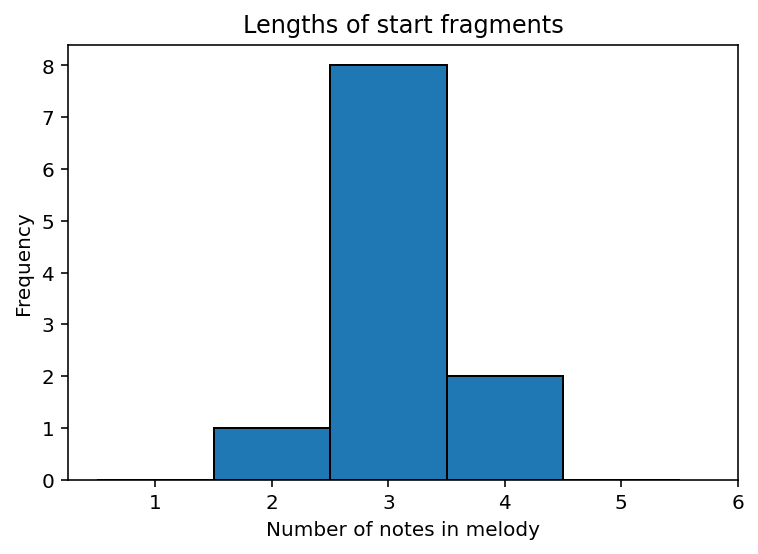

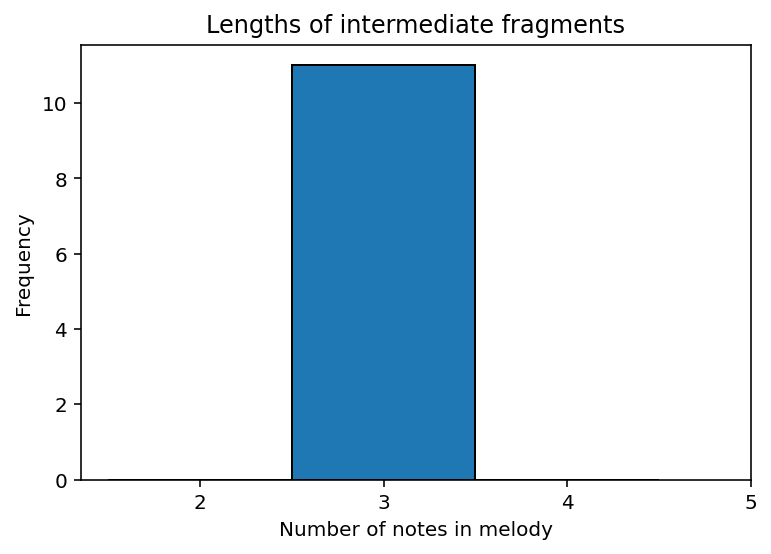

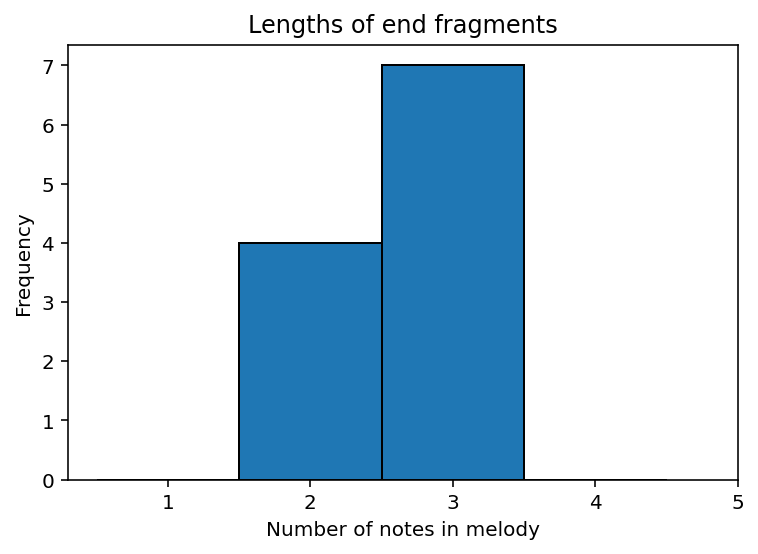

In [92]:
#length of each fragment of the melody
start_fragments = []
for i in range(corpus_size + 1):
    start_fragments.append(start_melody())
length_plot(start_fragments, title = 'Lengths of start fragments')
plt.savefig('supp_start_lengths.png', dpi = 300)

int_fragments = []
for i in range(corpus_size + 1):
    int_fragments.append(int_melody())
length_plot(int_fragments, title = 'Lengths of intermediate fragments')
plt.savefig('supp_int_lengths.png', dpi = 300)

end_fragments = []
for i in range(corpus_size + 1):
    end_fragments.append(end_melody())
length_plot(end_fragments, title = 'Lengths of end fragments')
plt.savefig('supp_end_lengths.png', dpi = 300)

In [93]:
#does the same thing as cleanup_corpus but appends 'end' to all melodies to mark where they end
#helps IC calculations because transitions between last and first notes are excluded
  #possibly a stupid thing because 'end' was in the original melody and then chopped off...

def cleanup_corpus_2(corpus):
  a = []
  for item in corpus:
    while 'end' not in item:
      item.append('end')
    a = a + item
  return a

melody_corpus = cleanup_corpus_2(melody_list)
sequence_corpus = cleanup_corpus_2(sequence_list)
#print(melody_corpus)

In [94]:
def calc_trans_probs_sequence(corpus): #usually matrix: current_matrix; corpus: melody_corpus
    degrees = [1,2,3,4,5,6,7]
    sequence_string = str(corpus)
    pitch_freqs = calc_pitch_freqs(degrees, corpus)
    transition_probs = {}

    for context in pitch_freqs.keys():
        next_note_probs = []
        for note in pitch_freqs:
            pattern = str(str(context)+", "+str(note))
            prob = len(re.findall(pattern, sequence_string))/pitch_freqs[context]
            next_note_probs.append(prob)
        transition_probs[context] = next_note_probs

    transition_probs = organize_matrix(transition_probs)
    transition_probs = transition_probs.transpose()
    return(transition_probs)

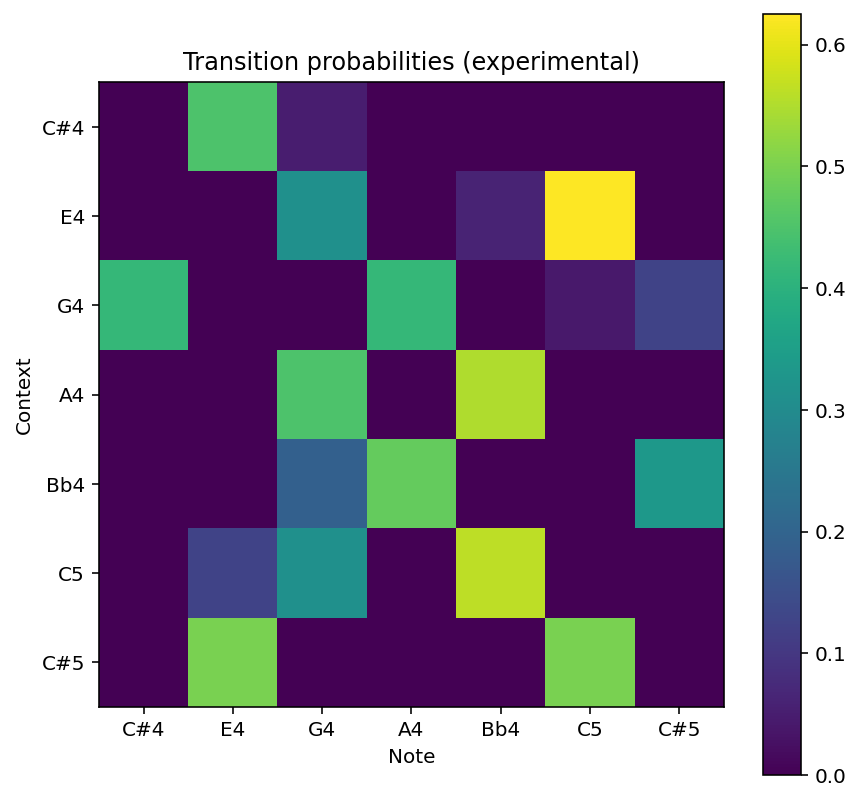

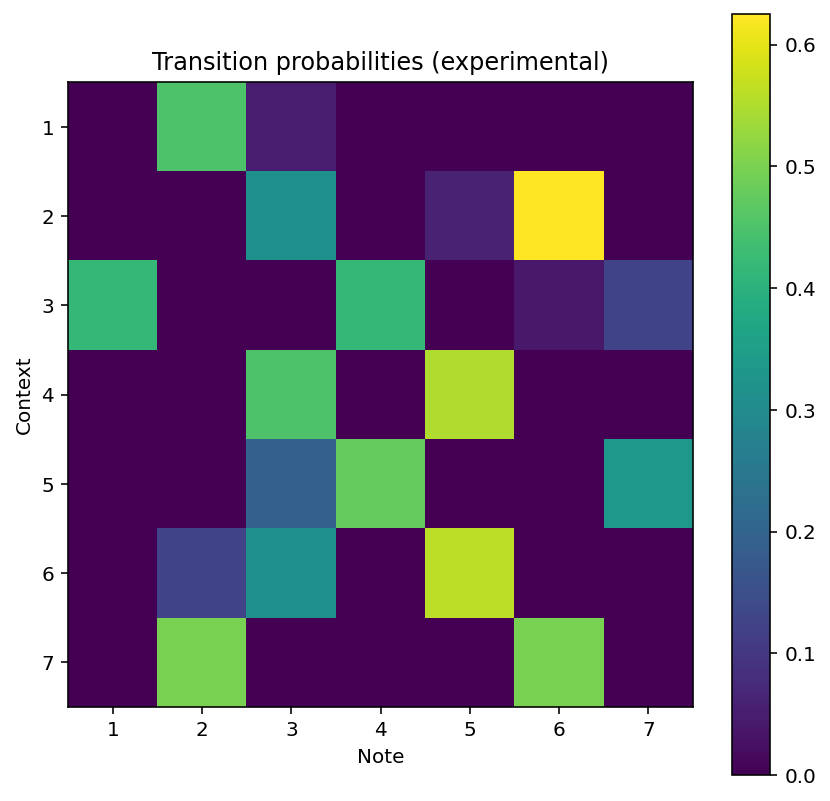

In [95]:
"""
I tried to rewrite the functions to analyze using the sequences instead of melodies... work in progress"""
seq_trans_probs = calc_trans_probs_sequence(sequence_corpus)
exp_trans_probs = calc_trans_probs(pitches, melody_corpus)

plot_matrix(exp_trans_probs, "Transition probabilities (experimental)")
plot_matrix(seq_trans_probs, "Transition probabilities (experimental)")

plt.savefig('trans_probs.png', dpi = 300)
#not possible to plot theoretical transition matrices like this because the melody consists of multiple cells
#plot_matrix(current_matrix, 'Transition probabilities (theoretical)')


['C#4''E4''C5''Bb4''A4''G4''C#5''C5''G4''A4''G4''C#4''end''C#4''G4''C5''Bb4''A4''Bb4''C#5''C5''G4''A4''G4''C#4''end''C#4''E4''C5''G4''A4''Bb4''C#5''C5''E4''Bb4''A4''Bb4''G4''C#4''end''C#4''E4''C5''Bb4''A4''Bb4''C#5''C5''E4''G4''A4''G4''C#4''end''C#4''E4''C5''Bb4''A4''G4''C#5''E4''C5''G4''A4''G4''C#4''end''C#4''E4''C5''Bb4''A4''Bb4''C#5''C5''G4''A4''G4''C#4''end''C#4''E4''C5''Bb4''A4''Bb4''C#5''E4''G4''A4''Bb4''G4''C#4''end''C#4''E4''C5''Bb4''A4''Bb4''C#5''E4''G4''A4''G4''C#4''end''C#4''E4''C5''Bb4''A4''G4''C#5''E4''G4''A4''Bb4''G4''C#4''end''C#4''E4''C5''Bb4''A4''Bb4''C#5''E4''G4''A4''Bb4''G4''C#4''end']


c:\Users\blueb\OneDrive\Documents\Schooool\2022-2023\consonance internship\online experiment drafts\melody generation working code\melody generation\analysis_functions.py:161: RuntimeWarning: divide by zero encountered in log2
  next_note_IC = [-np.log2(x) for x in next_note_probs]
c:\Users\blueb\OneDrive\Documents\Schooool\2022-2023\consonance internship\online experiment drafts\melody generation working code\melody generation\analysis_functions.py:180: RuntimeWarning: divide by zero encountered in log2
  next_note_IC = [-np.log2(x) for x in next_note_probs]


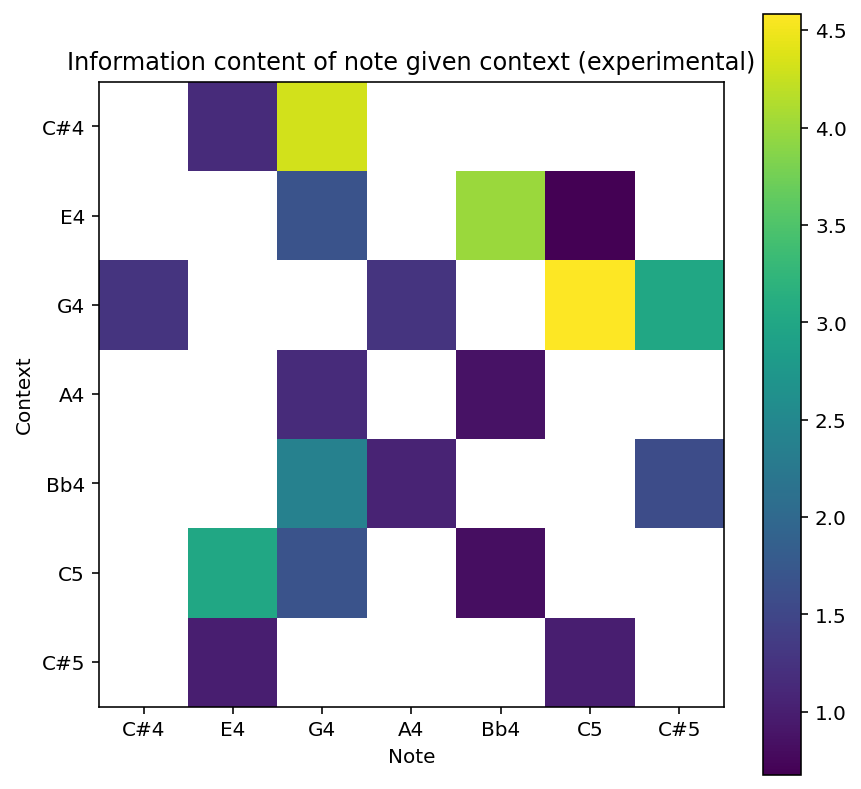

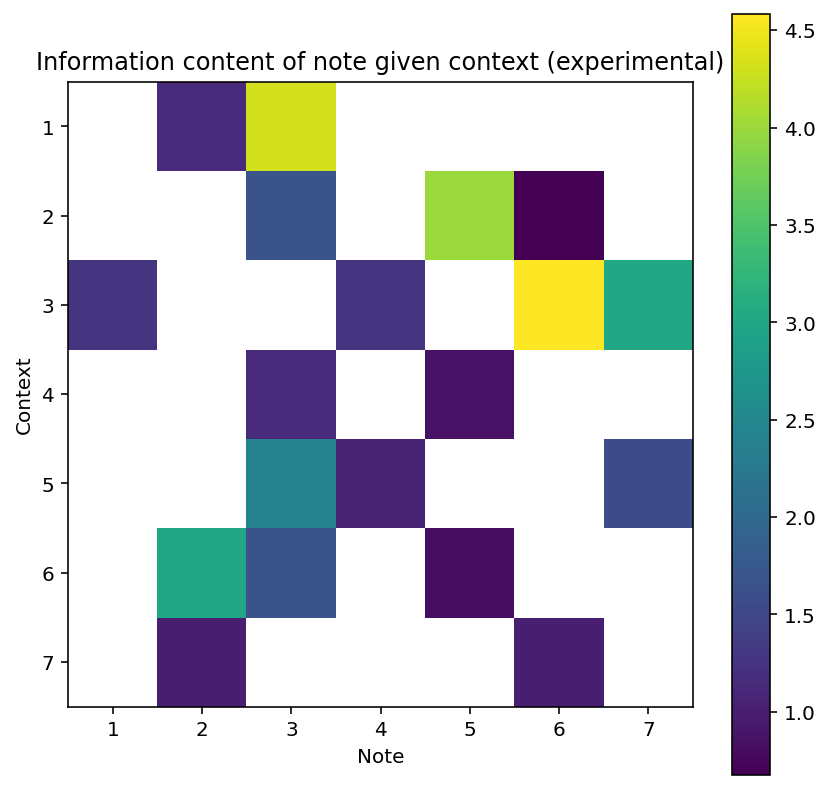

In [98]:
#information content of notes given context
exp_IC = calc_IC(pitches, melody_corpus)
exp_IC_seq = calc_IC_sequence(sequence_corpus)

plot_matrix(exp_IC, "Information content of note given context (experimental)")
plot_matrix(exp_IC_seq, "Information content of note given context (experimental)")
plt.savefig('IC.png', dpi = 300)

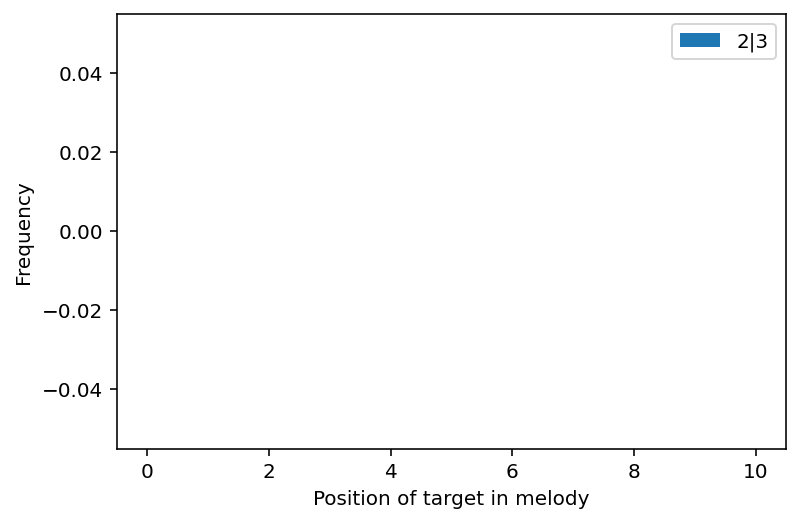

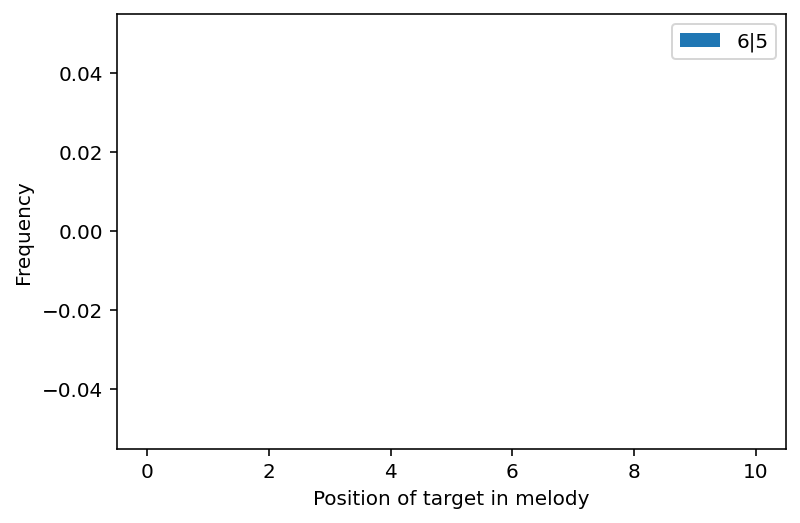

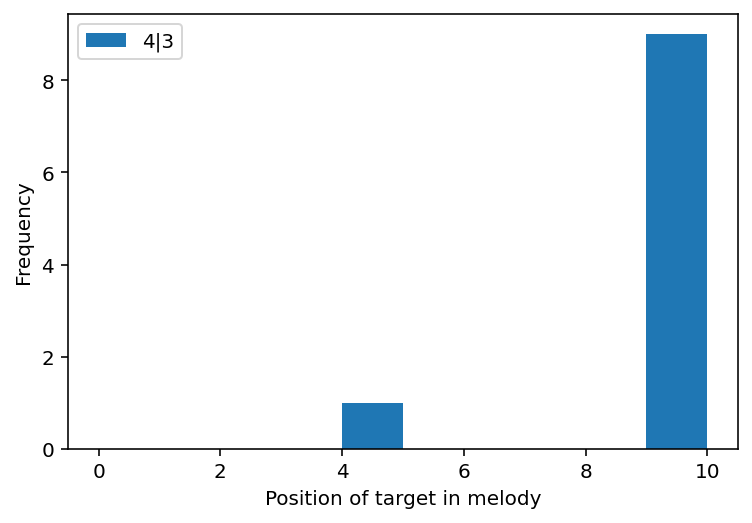

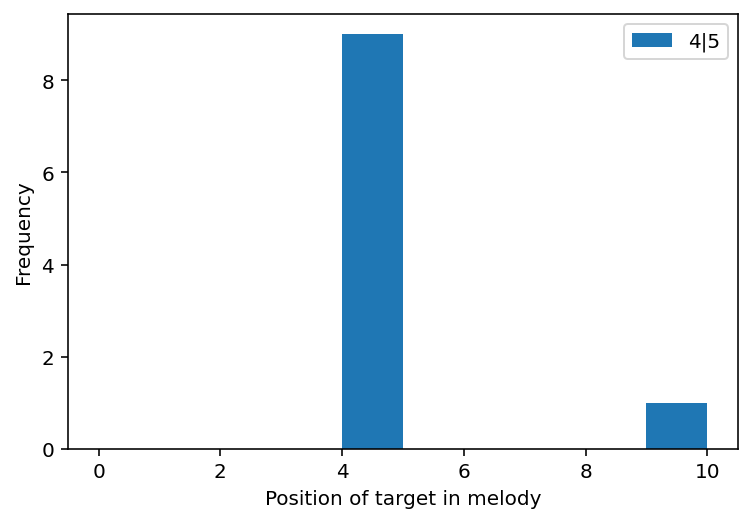

In [99]:
#finds position of target note given context within a melody (i.e. is the target note always the 2nd note?)
#target_finder(melody_list, target, context)

#high IC
target_finder(sequence_list, 2, 3)
plt.savefig('supp_target_pos_23.png', dpi = 300)
target_finder(sequence_list, 6, 5)
plt.savefig('supp_target_pos_65.png', dpi = 300)

#low IC
target_finder(sequence_list, 4, 3)
plt.savefig('supp_target_pos_43.png', dpi = 300)
target_finder(sequence_list, 4, 5)
plt.savefig('supp_target_pos_45.png', dpi = 300)
#target_finder(melody_list, 'Bb3', 'E4')

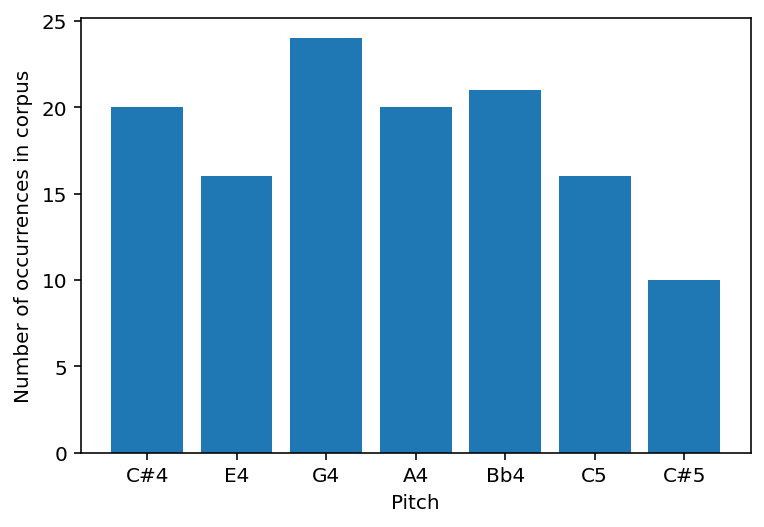

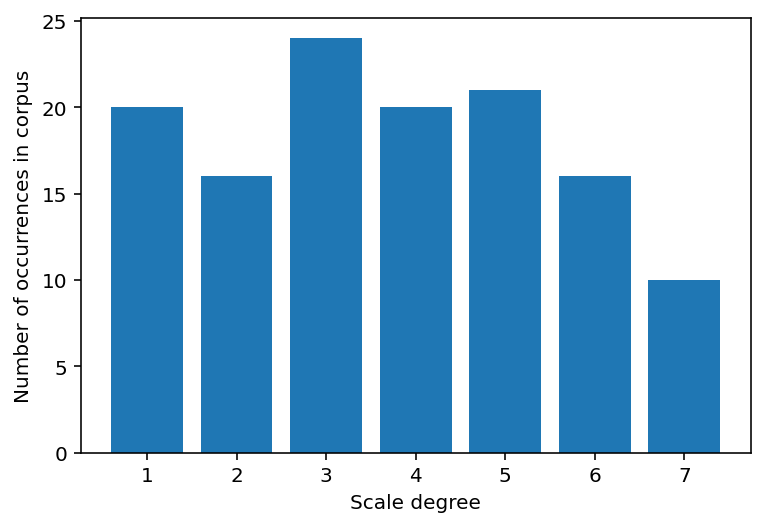

In [100]:
#counting frequency of notes
pitchfreqs = calc_pitch_freqs(pitches, melody_corpus)

plt.figure()
plt.bar(pitches, pitchfreqs.values())
plt.xlabel("Pitch")
plt.ylabel("Number of occurrences in corpus")


degreefreqs = calc_pitch_freqs(degrees, sequence_corpus)

plt.figure()
plt.bar(degrees, degreefreqs.values())
plt.xlabel("Scale degree")
plt.ylabel("Number of occurrences in corpus")

plt.savefig('supp_degree_freqs.png', dpi = 300)

In [101]:
print(degreefreqs.values())

dict_values([20, 16, 24, 20, 21, 16, 10])


PART 3: CONVERTING TO MIDI

In [102]:
#pickling the relevant corpuses for further analysis
def pickle_this(listname, filename):
    file_name = filename+".pkl"
    open_file = open(file_name, "wb")
    pickle.dump(listname, open_file)
    open_file.close()

Exposure melody generation

In [103]:
def midi_exposure(list, name):
  
  for item in list:
    melody = item
    if 'end' in item: 
            item.remove('end')
    stream_current = stream.Stream()
    stream_current.append(current_tempo)
    

    for j in melody: 
        #r_int = note.Rest(duration = duration.Duration(0.05))
        newnote = note.Note(j)
        newnote.volume = volume.Volume(velocity=40)
        stream_current.append(newnote)
        #stream_current.append(r_int)

        stream_current.write("midi", name+str(list.index(item)+1)+".mid")

In [104]:
def midi_exposure_4s(list, name): 
    name_index = 1
    for i in range(0,len(list)-3, 4):
        melody = list[i]+['rest1']+list[i+1]+['rest2']+list[i+2]+['rest3']+list[i+3]
        melody = [i for i in melody if i != 'end']

        stream_current = stream.Stream()
        stream_current.append(current_tempo)

        r1 = note.Rest(duration = duration.Duration(2))
        r2 = note.Rest(duration = duration.Duration(2))
        r3 = note.Rest(duration = duration.Duration(2))

        for j in melody: 
            if j == 'rest1':
                stream_current.append(r1)
            elif j == 'rest2':
                stream_current.append(r2)
            elif j == 'rest3':
                stream_current.append(r3)
            else:
                newnote = note.Note(j)
                newnote.volume = volume.Volume(velocity=40)
                stream_current.append(newnote)
            #stream_current.append(r_int)

        #stream_current.flat.notesAndRests.speed = 2.0

        stream_current.write("midi", name+str(name_index)+".mid")
        name_index += 1

In [105]:
midi_exposure_4s(melody_list, 'exposure_4s_')
pickle_this(sequence_list, "exposure_corpus")

In [106]:
midi_exposure(melody_list[0:9], 'grammatical_')
#pickle_this(sequence_list, "exposure_corpus")

In [107]:
midi_exposure(ag_melody_list, 'agrammatical_')
#don't need to pickle because sequences are the same

Forced choice melody generation

In [108]:
"""
making forced choice melodies. 
options: long or short 
    accent or no accent
"""

#generate sequences with proper IC
def generate_fc_sequence(context, target, length = 'long'):
    if length == 'short':
        return start_melody()+[context]+[target]+end_melody()
    elif length == 'long':
        contexts = [5,3]
        targets = [2,4,6]
        contexts.remove(context)
        targets.remove(target)

        target_position = np.random.choice([1,2])
        if target_position == 1:
            sequence = start_melody()+[context]+[target]+int_melody()+[np.random.choice(contexts)]+[np.random.choice(targets)]+end_melody()
        elif target_position == 2:
            sequence = start_melody()+[np.random.choice(contexts)]+[np.random.choice(targets)]+int_melody()+[context]+[target]+end_melody()
        return sequence

#generate streams with no accent
def to_stream_default(melody):
    stream_current = stream.Stream()
    stream_current.append(current_tempo)
    r = note.Rest(duration = duration.Duration(2))
    
    for j in range(len(melody)): 
        r_int = note.Rest(duration = duration.Duration(0.05))
        r_end = note.Rest(duration = duration.Duration(1))
        if melody[j] == 'rest':            
            stream_current.append(r)
        else:
            newnote = note.Note(melody[j])
            newnote.volume = volume.Volume(velocity= 40)
            stream_current.append(newnote)           
            #stream_current.append(r_int)
            
    stream_current.append(r_end)
    return stream_current


#generate streams with accent
def to_stream_accented(melody, context, target):
    context = seq_to_pitch([context])
    target = seq_to_pitch([target])
    stream_current = stream.Stream()
    stream_current.append(current_tempo)
    r = note.Rest(duration = duration.Duration(2))
  
    for j in range(len(melody)): 
        r_int = note.Rest(duration = duration.Duration(0.05))
        r_end = note.Rest(duration = duration.Duration(1))
        if melody[j] == 'rest':            
            stream_current.append(r)
        else:
            newnote = note.Note(melody[j])
            if melody[j] == target[0] and melody[j-1] == context[0]:
                newnote.volume = volume.Volume(velocity = 70)

            else:
                newnote.volume = volume.Volume(velocity= 40)
                
            stream_current.append(newnote)           
            #stream_current.append(r_int)
            
    stream_current.append(r_end)
    return stream_current

#put two streams into the same file
def concat_streams(stream1, stream2):
    stream_final = stream.Stream()
    stream_final.append(current_tempo)
    stream_final.append(stream1)
    stream_final.append(stream2)
    return stream_final

#convert streams to midi
def stream_to_midi(stream, name):
    stream.write("midi", name+".mid")


#generate a set of fc melodies where the same melody is repeated with and without accents
def fc_accents_midi(setsize, context, target, length):
    sequences = []
    for i in range(1, setsize+1):
        sequence = generate_fc_sequence(context, target, length)
        sequences.append(sequence)
        melody = seq_to_pitch(sequence)
        teststream_accent = to_stream_accented(melody, context, target)
        teststream_default = to_stream_default(melody)
        teststream_final = concat_streams(teststream_default, teststream_accent)
        stream_to_midi(teststream_final, 'fc_accents_'+str(context)+str(target)+'_'+str(i))

    pickle_this(sequences, 'fc_accents_'+str(length)+'_'+str(context)+str(target))

#generate a set of fc tests where the melody changes by one note differing in IC
def fc_IC_midi_default(setsize, context, length):
    target1 = context-1
    target2 = context+1
    sequences_1 = []
    
    for index in range(1, setsize+1):
        sequence1 = generate_fc_sequence(context, target1, length)
        sequence2 = sequence1.copy()
        for i in range(len(sequence2)):
            if sequence2[i] == target1 and sequence2[i-1] == context:
                sequence2[i] = target2
        sequences_1.append(sequence1)

        melody1 = seq_to_pitch(sequence1)
        melody2 = seq_to_pitch(sequence2)

        stream1 = to_stream_default(melody1)
        stream2 = to_stream_default(melody2)
        teststream_final = concat_streams(stream1, stream2)
        stream_to_midi(teststream_final, 'fc_IC_default_'+str(context)+'_'+str(index))
    pickle_this(sequences_1, 'fc_IC_default_'+str(length)+'_'+str(context))

def fc_IC_midi_accent(setsize, context, length):
    target1 = context-1
    target2 = context+1
    sequences_1 = []
    
    for index in range(1, setsize+1):
        sequence1 = generate_fc_sequence(context, target1, length)
        sequence2 = sequence1.copy()
        for i in range(len(sequence2)):
            if sequence2[i] == target1 and sequence2[i-1] == context:
                sequence2[i] = target2
        sequences_1.append(sequence1)

        melody1 = seq_to_pitch(sequence1)
        melody2 = seq_to_pitch(sequence2)

        stream1 = to_stream_accented(melody1, context, target1)
        stream2 = to_stream_accented(melody2, context, target2)
        teststream_final = concat_streams(stream1, stream2)
        stream_to_midi(teststream_final, 'fc_IC_accent_'+str(context)+'_'+str(index))
    pickle_this(sequences_1, 'fc_IC_accent_'+str(length)+'_'+str(context))

In [109]:
fc_accents_midi(setsize = 3, context = 3, target = 2, length = 'short')

<ipython-input-85-8f1abadd184a>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.random.choice([[5,3,1],[3,1]])


In [110]:
fc_accents_midi(setsize = 4, context = 3, target = 2, length = 'short')
fc_accents_midi(setsize = 4, context = 3, target = 4, length = 'short')

fc_accents_midi(setsize = 4, context = 5, target = 6, length = 'short')
fc_accents_midi(setsize = 4, context = 5, target = 4, length = 'short')

<ipython-input-85-8f1abadd184a>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.random.choice([[5,3,1],[3,1]])


In [111]:
fc_IC_midi_default(setsize = 4, context = 5, length = 'short')
fc_IC_midi_default(setsize = 4, context = 3, length = 'short')

fc_IC_midi_accent(setsize = 4, context = 5, length = 'short')
fc_IC_midi_accent(setsize = 4, context = 3, length = 'short')

<ipython-input-85-8f1abadd184a>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.random.choice([[5,3,1],[3,1]])


PART 4: CONVERTING TO MP3

In [112]:
#need to run on linux 

#installing fluidsynth
#!apt install fluidsynth
#!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [113]:
#stringmaker('stream', len(melody_list))

Extra: sample melodies

In [114]:
"""#set 1
HighIC = seq_to_pitch([1,3,3,2,5,6,5,2,3,1])
LowIC = seq_to_pitch([1,3,3,4,5,6,5,2,3,1])

volumes_1 = [40]*len(HighIC)
volumes_1_accent = [40]*len(HighIC)
volumes_1_accent[3] = 90

high_IC_default = stream_this(HighIC, volumes_1)
low_IC_default = stream_this(LowIC, volumes_1)
high_IC_accent = stream_this(HighIC, volumes_1_accent)
low_IC_accent = stream_this(LowIC, volumes_1_accent)

#neither melody has accent, only target note changes
highlowdefault = stream.Stream()
highlowdefault.append(high_IC_default)
highlowdefault.append(low_IC_default)
stream_to_midi(highlowdefault, 'highlowdefault')

#highIC target with and  without accent
highaccent = stream.Stream()
highaccent.append(high_IC_accent)
highaccent.append(high_IC_default)
stream_to_midi(highaccent, 'highaccent')

#lowIC target with and without accent
lowaccent = stream.Stream()
lowaccent.append(low_IC_accent)
lowaccent.append(low_IC_default)
stream_to_midi(lowaccent, 'lowaccent')

#both melodies have accent, only target note changes
highlowaccent = stream.Stream()
highlowaccent.append(low_IC_accent)
highlowaccent.append(high_IC_accent)
stream_to_midi(highlowaccent, 'highlowaccent')

"""

"#set 1\nHighIC = seq_to_pitch([1,3,3,2,5,6,5,2,3,1])\nLowIC = seq_to_pitch([1,3,3,4,5,6,5,2,3,1])\n\nvolumes_1 = [40]*len(HighIC)\nvolumes_1_accent = [40]*len(HighIC)\nvolumes_1_accent[3] = 90\n\nhigh_IC_default = stream_this(HighIC, volumes_1)\nlow_IC_default = stream_this(LowIC, volumes_1)\nhigh_IC_accent = stream_this(HighIC, volumes_1_accent)\nlow_IC_accent = stream_this(LowIC, volumes_1_accent)\n\n#neither melody has accent, only target note changes\nhighlowdefault = stream.Stream()\nhighlowdefault.append(high_IC_default)\nhighlowdefault.append(low_IC_default)\nstream_to_midi(highlowdefault, 'highlowdefault')\n\n#highIC target with and  without accent\nhighaccent = stream.Stream()\nhighaccent.append(high_IC_accent)\nhighaccent.append(high_IC_default)\nstream_to_midi(highaccent, 'highaccent')\n\n#lowIC target with and without accent\nlowaccent = stream.Stream()\nlowaccent.append(low_IC_accent)\nlowaccent.append(low_IC_default)\nstream_to_midi(lowaccent, 'lowaccent')\n\n#both melod

In [115]:
"""#set 2 (shorter melodies)
HighIC_short = seq_to_pitch([1,3,3,2,3,1])
LowIC_short = seq_to_pitch([1,3,3,4,3,1])

volumes_short = [40]*len(HighIC)
volumes_short_accent = [40]*len(HighIC)
volumes_short_accent[3] = 90

high_IC_short_default = stream_this(HighIC_short, volumes_short)
low_IC_short_default = stream_this(LowIC_short, volumes_short)
high_IC_short_accent = stream_this(HighIC_short, volumes_short_accent)
low_IC_short_accent = stream_this(LowIC_short, volumes_short_accent)

#both melodies have accent, only target note changes
highlowaccent_short = stream.Stream()
highlowaccent_short.append(low_IC_short_accent)
highlowaccent_short.append(high_IC_short_accent)
stream_to_midi(highlowaccent_short, 'highlowaccent_short')"""

"#set 2 (shorter melodies)\nHighIC_short = seq_to_pitch([1,3,3,2,3,1])\nLowIC_short = seq_to_pitch([1,3,3,4,3,1])\n\nvolumes_short = [40]*len(HighIC)\nvolumes_short_accent = [40]*len(HighIC)\nvolumes_short_accent[3] = 90\n\nhigh_IC_short_default = stream_this(HighIC_short, volumes_short)\nlow_IC_short_default = stream_this(LowIC_short, volumes_short)\nhigh_IC_short_accent = stream_this(HighIC_short, volumes_short_accent)\nlow_IC_short_accent = stream_this(LowIC_short, volumes_short_accent)\n\n#both melodies have accent, only target note changes\nhighlowaccent_short = stream.Stream()\nhighlowaccent_short.append(low_IC_short_accent)\nhighlowaccent_short.append(high_IC_short_accent)\nstream_to_midi(highlowaccent_short, 'highlowaccent_short')"

In [116]:
"""#set 3 (exposure phase checking whether grammar was learned)
agrammatical_1 = seq_to_pitch([1,2,3,2,1,4,5,2,3,1])
aggramatical = stream_this(agrammatical_1, volumes_1)

grammar_test = stream.Stream()
grammar_test.append(aggramatical)
grammar_test.append(high_IC_default)

stream_to_midi(grammar_test, 'grammar_test')"""

"#set 3 (exposure phase checking whether grammar was learned)\nagrammatical_1 = seq_to_pitch([1,2,3,2,1,4,5,2,3,1])\naggramatical = stream_this(agrammatical_1, volumes_1)\n\ngrammar_test = stream.Stream()\ngrammar_test.append(aggramatical)\ngrammar_test.append(high_IC_default)\n\nstream_to_midi(grammar_test, 'grammar_test')"

Extra: generating small files for soundcheck


In [117]:
def midi_this(melody, accent_position, name): 
    stream_current = stream.Stream()
    r = note.Rest(duration = duration.Duration(2))
    
    for j in range(len(melody)): 
        r_int = note.Rest(duration = duration.Duration(0.05))
        r_end = note.Rest(duration = duration.Duration(1))
        if melody[j] == 'rest':            
            stream_current.append(r)
        else:
            newnote = note.Note(melody[j], duration = duration.Duration(0.7))
            if j == accent_position:
                newnote.volume = volume.Volume(velocity=90)
            else:
                newnote.volume = volume.Volume(velocity= 40)
            stream_current.append(newnote)           
            #stream_current.append(r_int)
            
    stream_current.append(r_end)
    stream_current.write("midi", str(name)+".mid")




Attention checks

In [118]:
#which melody is higher? --> decided the task is too easy
#midi_this(['G4', 'Bb4', 'E5', 'C5', 'Bb4', 'A4', 'Bb4', 'G5', 'A4', 'C#5', 'C5', 'Bb4', 'G4', 'rest', 'G3', 'Bb3', 'E4', 'C4', 'Bb3', 'A3', 'Bb3', 'G4', 'A3', 'C#4', 'C4', 'Bb3', 'G3'], None, 'attn_highlow')

#midi_this(['G4', 'Bb4', 'E5', 'C5', 'Bb4', 'A4', 'Bb4', 'G5', 'A4', 'C#5', 'C5', 'Bb4', 'G4', 'rest', 'G5', 'Bb5', 'E6', 'C6', 'Bb5', 'A5', 'Bb5', 'G6', 'A5', 'C#6', 'C6', 'Bb5', 'G5'], None, 'attn_lowhigh')

In [119]:
#which melody is longer?
exp1 = seq_to_pitch([1, 2, 6, 3, 2, 5, 7, 2, 5, 4, 3, 1])
exp2 = seq_to_pitch([1, 2, 3, 6, 5, 6, 5, 7, 6, 3, 4, 5, 3, 1])

fc1 = seq_to_pitch([1, 2, 5, 6, 5, 3, 1])
fc2 = seq_to_pitch([1, 3, 6, 4, 3, 4, 5, 3, 1])

#easy mode: exp vs fc
#intermediate mode: fc vs fc
#hard mode: exp vs exp

#midi_this(['G4', 'Bb4', 'E5', 'C5', 'Bb4', 'A4', 'Bb4', 'G5', 'A4', 'C#5', 'C5', 'Bb4', 'G4', 'rest', 'G4', 'Bb4', 'E5', 'C5', 'Bb4', 'A4', 'Bb4', 'G4'], None, 'attn_length_easy_1')



midi_this(exp1+['rest']+exp2, None, 'attn_length_hard_1')
midi_this(fc1+['rest']+fc2, None, 'attn_length_int_1')
midi_this(fc1+['rest']+exp1, None, 'attn_length_easy_1')


In [120]:
for i in range(1, 46):
    print('"exposure_4s_'+str(i)+'.mp3",')

"exposure_4s_1.mp3",
"exposure_4s_2.mp3",
"exposure_4s_3.mp3",
"exposure_4s_4.mp3",
"exposure_4s_5.mp3",
"exposure_4s_6.mp3",
"exposure_4s_7.mp3",
"exposure_4s_8.mp3",
"exposure_4s_9.mp3",
"exposure_4s_10.mp3",
"exposure_4s_11.mp3",
"exposure_4s_12.mp3",
"exposure_4s_13.mp3",
"exposure_4s_14.mp3",
"exposure_4s_15.mp3",
"exposure_4s_16.mp3",
"exposure_4s_17.mp3",
"exposure_4s_18.mp3",
"exposure_4s_19.mp3",
"exposure_4s_20.mp3",
"exposure_4s_21.mp3",
"exposure_4s_22.mp3",
"exposure_4s_23.mp3",
"exposure_4s_24.mp3",
"exposure_4s_25.mp3",
"exposure_4s_26.mp3",
"exposure_4s_27.mp3",
"exposure_4s_28.mp3",
"exposure_4s_29.mp3",
"exposure_4s_30.mp3",
"exposure_4s_31.mp3",
"exposure_4s_32.mp3",
"exposure_4s_33.mp3",
"exposure_4s_34.mp3",
"exposure_4s_35.mp3",
"exposure_4s_36.mp3",
"exposure_4s_37.mp3",
"exposure_4s_38.mp3",
"exposure_4s_39.mp3",
"exposure_4s_40.mp3",
"exposure_4s_41.mp3",
"exposure_4s_42.mp3",
"exposure_4s_43.mp3",
"exposure_4s_44.mp3",
"exposure_4s_45.mp3",
